# A Influência da Dimensão Espacial nos Valores Médios das Rendas Habitacionais: Uma Análise Econométrica Espacial das Freguesias da Região de Aveiro

### Quais os fatores espaciais que influenciam a variação dos valores médios das rendas dos alojamentos nas freguesias da região de Aveiro?

A variação dos valores das rendas nas freguesias da Região Aveiro não é aleatória, sendo influenciada por fatores espaciais como proximidade a centros urbanos, acessibilidade e dinâmica socioeconómica. A econometria permite analisar se há dependência espacial, ou seja, se os preços das rendas numa freguesia são influenciados pelos das freguesias vizinhas. Identificar esses padrões ajuda a compreender a formação dos preços, detetar clusters de rendas elevadas e fornecer informações relevantes para políticas habitacionais e planeamento urbano mais eficientes.

### Configuração do Ambiente e Importação de Bibliotecas

#### Importação de Bibliotecas

In [214]:
pip install pysal

Note: you may need to restart the kernel to use updated packages.


In [215]:
import os
import sys
import importlib
from pathlib import Path

import pandas as pd
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt
import contextily as cx

import folium

from pyogrio import list_layers

#### Definição da diretoria de trabalho na diretoria raiz do projeto

In [216]:
from pathlib import Path

# Find the project root (assuming marker-based or script-relative path)
def find_project_root(marker="README.md"):
    current_dir = Path.cwd()
    while current_dir != current_dir.parent:  # Traverse up until root
        if (current_dir / marker).exists():
            return current_dir
        current_dir = current_dir.parent
    raise FileNotFoundError(f"Marker '{marker}' not found in any parent directory.")

project_root = find_project_root()
sys.path.append(str(project_root))

# Or use a relative path: project_root = Path(__file__).resolve().parent.parent
os.chdir(project_root)
print(f"Working directory set to: {project_root}")

Working directory set to: /Users/filipasantos/Desktop/Mestrado CDACS/2º Semestre/ETE


In [217]:
module_path = os.path.abspath(os.path.join(r'.\src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [218]:
import utils.utils_ete2425

## Análise Espacial de Recursos Urbanos e Acessibilidade na Escala Local

### Preparação e Estruturação dos Dados Geoespaciais

Prepararam-se os dados geoespaciais que servirão como base para associar as freguesias aos valores da variável em estudo. Através do BGRI (Base Geográfica de Referenciação da Informação), obtêm-se unidades espaciais detalhadas da Região de Aveiro, delimitando a área de análise. Por outro lado, o CAOP (Carta Administrativa Oficial de Portugal) fornece os limites administrativos, sendo as freguesias a unidade territorial de interesse.

Para garantir a compatibilidade e facilitar a análise espacial, os dados converteram-se para o sistema de coordenadas global WGS84 (EPSG:4326). Esta transformação permite uma melhor integração dos dados em análises espaciais, mapas interativos e modelação econométrica espacial, assegurando que todas as camadas de informação estejam alinhadas no mesmo referencial.

#### Carregamento de Dados Geoespaciais

BGRI: https://mapas.ine.pt/download/index2021

REGIAO DE AVEIRO [BGRI21_16D.gpkg](https://mapas.ine.pt/download/filesGPG/2021/nuts3/BGRI21_16D.zip)

NUTS3: 191 região de aveiro.
link [CAOP2024](https://www.dgterritorio.gov.pt/sites/default/files/ficheiros-cartografia/Areas_Freg_Mun_Dist_Pais_CAOP2024.zip)


In [219]:
shape_REGIAO_AVEIRO = gpd.read_file(r'BGRI21_16D.gpkg', layer='BGRI21_16D')
#shape_REGIAO_AVEIRO = gpd.read_file(r'.\data\input' + r'\HW01\BGRI21_16D.gpkg', layer = 'BGRI21_16D' )
shape_REG_AVEIRO_WGS84 = shape_REGIAO_AVEIRO.to_crs(epsg=4326)

### Processamento e Análise dos Dados Espaciais e das Rendas Habitacionais

#### Carregamento e Estruturação dos Dados das Rendas Habitacionais

Optou-se pelo seguinte indicador disponibilizado pelo INE (Instituto Nacional de Estatística): **Valor médio mensal das rendas dos alojamentos familiares clássicos arrendados (€) por Localização geográfica à data dos Censos [2021] (NUTS - 2013). Decenal – INE, Recenseamento da população e habitação – Censos 2021**. Nota-se que este indicador representa uma visão geral do mercado de arrendamento, agregando transações realizadas em diferentes momentos no tempo. Como está associado à operação censitária, apresenta uma cobertura abrangente, incluindo todas as freguesias do país e unidades espaciais de fins estatísticos, como as subsecções.

A seleção dos dados deste indicador incidiu exclusivamente sobre a Região de Aveiro, garantindo que a análise concentra-se apenas no território em estudo.

In [220]:
#db_excel_ine_rendaHab = pd.read_excel(r'.\data\input\HW01\HW01.xlsx',
#                                       skiprows=9,
#                                       skipfooter=5, header=None,
#                                       dtype='str'
#                                       )
db_excel_ine_rendaHab = pd.read_excel(r'HW01.xlsx',
                                       skiprows=9,
                                       skipfooter=5, header=None,
                                       dtype='str'
                                       )
db_excel_ine_rendaHab.rename(columns={0:"Designacao", 1:"GeoCod", 2:"ValMed_RendaMen"}, inplace=True)

In [221]:
#visualizando as duas primeiras observações (0,1) e as duas ultimas (-2,-1)
db_excel_ine_rendaHab.iloc[[0,1,-2,-1]]

,Designacao,GeoCod,ValMed_RendaMen
0,Região de Aveiro,16D,321.38
1,Águeda,0101,278.43
84,União das freguesias de Ponte de Vagos e Santa...,011813,294.26
85,União das freguesias de Vagos e Santo António,011814,315.68


In [222]:
db_excel_ine_rendaHab['LEVEL'] = db_excel_ine_rendaHab['GeoCod'].str.len()

db_excel_ine_rendaHab.head(4)

,Designacao,GeoCod,ValMed_RendaMen,LEVEL
0,Região de Aveiro,16D,321.38,3
1,Águeda,0101,278.43,4
2,Aguada de Cima,010103,256.49,6
3,Fermentelos,010109,277,6


In [223]:
#selecionando apenas as freguesias
db_excel_ine_rendaHab_freg = db_excel_ine_rendaHab[db_excel_ine_rendaHab['LEVEL'] == 6]
db_excel_ine_rendaHab_freg.iloc[0:3]

,Designacao,GeoCod,ValMed_RendaMen,LEVEL
2,Aguada de Cima,010103,256.49,6
3,Fermentelos,010109,277,6
4,Macinhata do Vouga,010112,262.7,6


#### Construção de Polígonos por freguesia para Análise Espacial

In [224]:
agg_columns = shape_REG_AVEIRO_WGS84.columns[13:45].tolist()

agg_dict = {col: 'sum' for col in agg_columns}

In [225]:
# Criar uma representação geométrica do municipio (polígono único)
# Permite-nos ter uma representação dos limites da área de estudo
# Atenção que mantém o mesmo referencial geográfico dos dados originais
shape_REG_Aveiro = shape_REG_AVEIRO_WGS84.dissolve(by='DTMNFR21', aggfunc=agg_dict)
#agrega a area para as freguesias

**Notas:**

Optámos por representar as freguesias através de **polígonos georreferenciados**, pois esta abordagem permite uma visualização clara da distribuição espacial das rendas da habitação. O uso de shapefiles (ficheiros extraídos do INE) facilita a sobreposição com dados estatísticos e a criação de matrizes de vizinhança.

Este tipo de representação, muito comum em análises econométricas espaciais,ajuda a perceber se freguesias próximas têm valores parecidos ou se há grandes diferenças entre vizinhos. Também nos permite calcular as distâncias entre freguesias e ver se os preços das rendas influenciam-se uns aos outros, fatores fundamentais para avaliar a dependência espacial e a autocorrelação dos dados.

#### Integração das Rendas Habitacionais com os Dados Espaciais

In [226]:
db_excel_ine_rendaHab_freg = db_excel_ine_rendaHab_freg.copy()
db_excel_ine_rendaHab_freg.rename(columns={"GeoCod":"DTMNFR21"}, inplace=True)
db_excel_ine_rendaHab_freg['ValMed_RendaMen'] = db_excel_ine_rendaHab_freg['ValMed_RendaMen'].astype(float)

In [227]:
shape_REG_Aveiro_rendaHab = shape_REG_Aveiro.merge(db_excel_ine_rendaHab_freg, left_on = 'DTMNFR21', right_on = 'DTMNFR21', how = 'left')

#### Visualização da Distribuição Espacial das Rendas

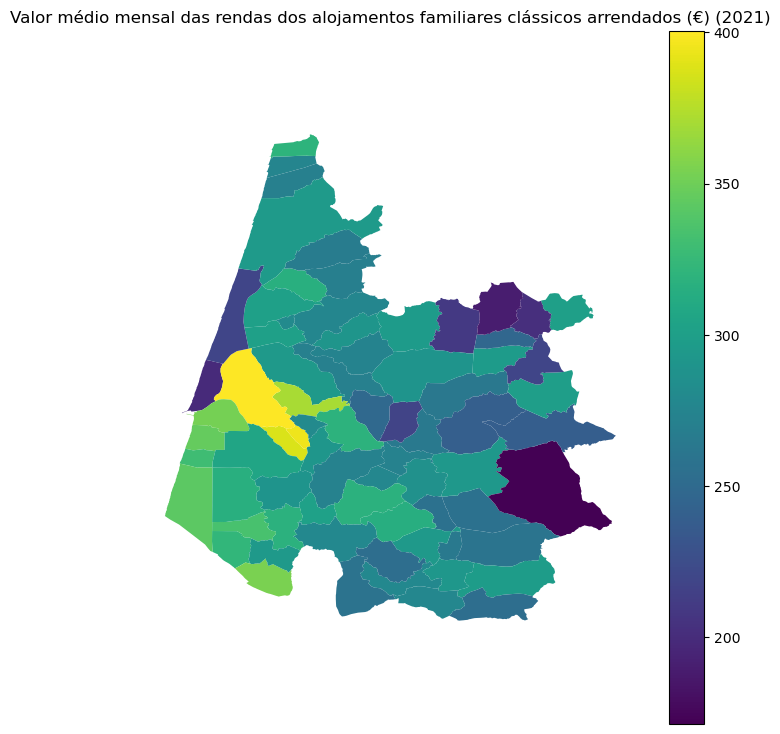

In [228]:
figura, ax = plt.subplots(1, figsize=(8, 9))
shape_REG_Aveiro_rendaHab.plot(ax=ax, column='ValMed_RendaMen',
                               legend=True)
ax.set_axis_off()
ax.set_title('Valor médio mensal das rendas dos alojamentos familiares clássicos arrendados (€) (2021)')
plt.axis('equal')
plt.show()

**Análise:**

O mapa apresenta a distribuição espacial dos valores médios das rendas dos alojamentos familiares arrendados na região de Aveiro à data de 2021. A escala de cores *indica* uma variação significativa nos preços, com valores mais baixos representados por tons azulados e mais elevados por tons amarelados.

Observa-se que as freguesias com rendas mais elevadas estão concentradas na faixa ocidental da região, especialmente próximas ao litoral, onde há uma maior atratividade económica e turística. Em contraste, as freguesias do interior apresentam rendas mais reduzidas, sugerindo menor pressão da procura habitacional.

Uma exceção a este padrão verifica-se na área que inclui S. Jacinto e Torreira, onde as rendas médias são relativamente baixas, apesar da proximidade ao litoral. Esta discrepância pode estar associada a fatores como acessibilidade limitada, menor desenvolvimento urbano ou um mercado imobiliário menos dinâmico em comparação com outras zonas costeiras da região.

A distribuição espacial sugere a presença de dependência espacial, uma característica relevante para a análise econométrica. Freguesias adjacentes tendem a exibir valores semelhantes e próximos entre si, o que pode indicar a influência de fatores regionais como acessibilidade, oferta imobiliária e a dinâmica do mercado local.

#### Análise da Distribuição das Rendas e Classificação dos Dados

In [229]:
# https://pysal.org/mapclassify/api.html
# pysal.viz »» mapclassify
import mapclassify as mc

import seaborn as sns

In [230]:
shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].describe().round(1)

count     74.0
mean     285.3
std       44.7
min      171.4
25%      263.0
50%      287.9
75%      304.6
max      400.4
Name: ValMed_RendaMen, dtype: float64


A visualização dos padrões geográficos das variáveis constitui um elemento chave na análise exploratória dos dados espacias.
No entanto, a visualização requer a configuração de paletes de cor para descrever as características marcantes dos dados. Importa assim perceber a distribuição dos dados e fornecer uma palete de cores que nos descreva as propriedades mais marcantes dessa distribuição.

Importa assim conjugar a exploração gráfica da distribuição dos dados - para a qual recorremos à livraria mapclassify e seaborn - bem como a sua visualização geográfica.

In [231]:
# Intervalos iguais

classi = mc.EqualInterval(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], k=7)
classi

EqualInterval

    Interval       Count
------------------------
[171.41, 204.12] |     4
(204.12, 236.84] |     4
(236.84, 269.55] |    15
(269.55, 302.27] |    32
(302.27, 334.98] |    11
(334.98, 367.70] |     4
(367.70, 400.41] |     4

##### Quantiles

In [232]:
classi_quant = mc.Quantiles(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], k=6)
classi_quant

Quantiles

    Interval       Count
------------------------
[171.41, 253.36] |    13
(253.36, 271.02] |    12
(271.02, 287.92] |    12
(287.92, 296.85] |    12
(296.85, 318.41] |    12
(318.41, 400.41] |    13

In [233]:
classi_quant.bins

array([253.35666667, 271.01666667, 287.92      , 296.85      ,
       318.41      , 400.41      ])

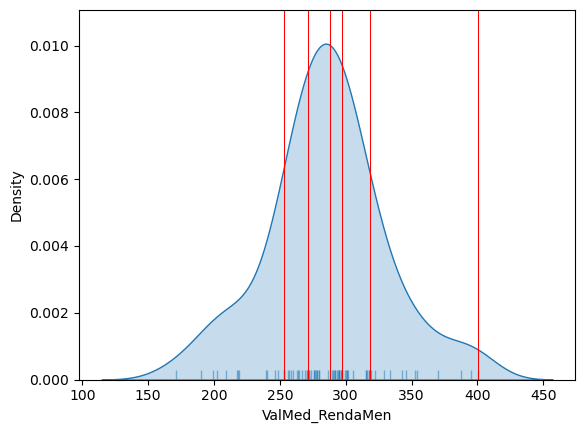

In [234]:
# Código padrão - usa a livraria seaborn (extende a matplotlib )
# https://seaborn.pydata.org/tutorial.html
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], fill=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi_quant.bins:
    plt.axvline(cut, color='red', linewidth=0.75)

**Análise:**

O gráfico anterior é um gráfico de densidade KDE (Kernel Density Estimation) que representa a distribuição dos valores médios das rendas habitacionais nas freguesias da Região de Aveiro.

A forma do gráfico sugere que os valores das rendas seguem uma distribuição aproximadamente normal, com uma leve assimetria à direita. Maior parte dos valores das rendas está concentrada entre 230 € e 360 €, aproximadamente, com um pico próximo dos 280 €, que representa a moda da distribuição. É de notar, ainda, que existem algumas freguesias com rendas superiores a 400 €, podendo indicar a presença de valores atípicos (outliers) em zonas específicas.

As linhas vermelhas representam os intervalos definidos pelo método dos quantis, dividindo os dados em 6 classes de igual frequência. É possível observar que maior parte das freguesias está nos quantis centrais, reforçando a ideia de que os preços são relativamente homogéneos na região de Aveiro, embora haja alguma variação. A presença de quantis próximos entre si no centro da distribuição indica uma alta concentração de valores de rendas próximos, enquanto os quantis mais distantes nas extremidades sugerem que existem algumas freguesias com rendas significativamente mais baixas ou mais altas.

O gráfico confirma a existência de variabilidade espacial nos preços das rendas na região em estudo, justificando a necessidade de uma análise econométrica espacial de forma a entender melhor os fatores que influenciam essa variação.

#### Classificação das Rendas Habitacionais

Diferentes métodos estatísticos de classificação são aplicados aos valores das rendas. O **desvio padrão** separa os dados com base na média e no desvio padrão, o **boxplot** segmenta os dados conforme quartis, considerando a distribuição da variável, e o **Fisher Jenks** otimiza a separação de classes minimizando a variância dentro de cada grupo, auxiliando na segmentação espacial dos valores das rendas e na identificação de padrões estruturais.

In [235]:
# Desvio padrão médio
classi = mc.StdMean(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
classi

StdMean

    Interval       Count
------------------------
[171.41, 195.96] |     2
(195.96, 240.64] |     8
(240.64, 329.99] |    55
(329.99, 374.67] |     6
(374.67, 400.41] |     3

In [236]:
# Baseado na caixa de bigodes
classi = mc.BoxPlot(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
classi

BoxPlot

    Interval       Count
------------------------
[171.41, 200.63] |     3
(200.63, 263.03] |    16
(263.03, 287.92] |    18
(287.92, 304.63] |    18
(304.63, 367.03] |    15
(367.03, 400.41] |     4

In [237]:
# Fisher Jenks

classi = mc.FisherJenks(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
classi

FisherJenks

    Interval       Count
------------------------
[171.41, 218.64] |     8
(218.64, 278.46] |    26
(278.46, 305.63] |    22
(305.63, 354.46] |    14
(354.46, 400.41] |     4

#### Construção da Matriz de Pesos Espaciais

A matriz de pesos é essencial para modelar a dependência espacial. Definem-se vizinhanças com base no compartilhamento de fronteiras ou vértices, permitindo avaliar se as rendas numa freguesia estão correlacionadas com as das freguesias vizinhas.

In [238]:
import scipy

In [239]:
from pysal.lib import weights


# # https://pysal.org/libpysal/api.html
# from libpysal.weights.contiguity import Queen

# from libpysal.cg import voronoi_frames

In [240]:
# Contiguidade Queen
w_rook_shape_REG_Aveiro_rendaHab = weights.contiguity.Queen.from_dataframe(shape_REG_Aveiro_rendaHab)

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_21574/1002145741.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_rook_shape_REG_Aveiro_rendaHab = weights.contiguity.Queen.from_dataframe(shape_REG_Aveiro_rendaHab)


In [241]:
shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].describe()

count     74.000000
mean     285.316351
std       44.678263
min      171.410000
25%      263.032500
50%      287.920000
75%      304.632500
max      400.410000
Name: ValMed_RendaMen, dtype: float64

In [242]:
shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].isna().sum()

np.int64(0)

**Nota:** Não há dados em falta, portanto não é necessário a imputação de dados.

### Associação (autocorrelação) espacial

A associação espacial emerge nos dados quando é possível observar correlações entre observações «próximas». Na análise univariada, pode-se calcular o "Índice de Moran - Índice Global de Associação Espacial" bem como a sua "variante" local: o "Índice Local de Associação Espacial" LISA (na sigla inglesa).

#### Associação espacial - Global

O **índice de Moran** mede a autocorrelação espacial, ou seja, verifica se há uma relação estatística entre os valores das rendas e os valores das freguesias vizinhas. Se os valores próximos forem muito semelhantes, existe autocorrelação espacial positiva, caso sejam muito diferentes, há autocorrelação espacial negativa.

Moran’s I é definido por:
$$
I = \frac{N}{W}\frac{\sum_{i} \sum_{j} w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i} (x_i - \bar{x})^2}
$$
onde:
- $( N )$ é o número total de observações no espaço
- $( W )$ é a soma de todos os pesos $( w_{ij} )$
- $( x_i )$ é o valor observado na localização $( i )$
- $( \bar{x} )$ é a média de todas as observações
- $( w_{ij} )$ é o peso espacial entre locais $( i )$ e $( j )$


**Interpretação de Moran's I:**
- $I > 0$ indica autocorrelação espacial positiva (valores similares próximos).
- $I < 0$ indica autocorrelação espacial negativa (valores dissimilares próximos).
- $I \approx 0$ indica ausência de autocorrelação espacial.



In [243]:
# Calcular o "spatial lag" (desfasamento espacial)

precoM2_lag = weights.lag_spatial(w_rook_shape_REG_Aveiro_rendaHab, shape_REG_Aveiro_rendaHab['ValMed_RendaMen'])
shape_REG_Aveiro_rendaHab["ValMed_RendaMen_lag"] = precoM2_lag

In [244]:
# "Normalizar" (cálculo de z-scores) as variáveis (original e desfasada)
shape_REG_Aveiro_rendaHab['ValMed_RendaMen_std'] = ( shape_REG_Aveiro_rendaHab['ValMed_RendaMen'] - shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].mean() )\
                    / shape_REG_Aveiro_rendaHab['ValMed_RendaMen'].std()
shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag_std'] = ( shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag'] - shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag'].mean() )\
                    / shape_REG_Aveiro_rendaHab['ValMed_RendaMen_lag'].std()

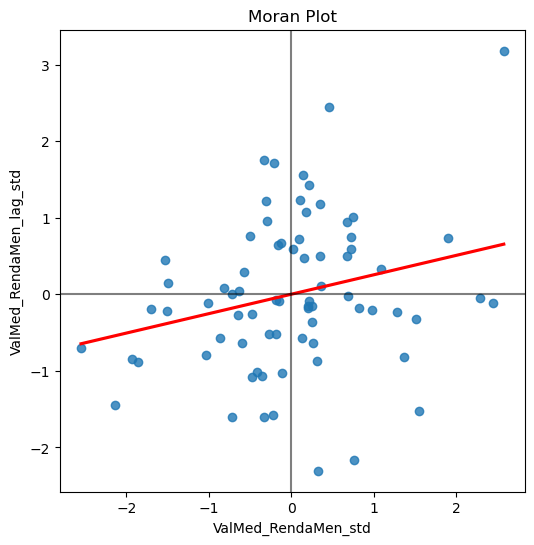

In [245]:
# Moran Plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='ValMed_RendaMen_std', y='ValMed_RendaMen_lag_std',
                ci=None, data=shape_REG_Aveiro_rendaHab, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot')
plt.show()

**Análise:**

O gráfico acima apresentado mostra a relação entre os valores normalizados da variável de interesse (renda habitacional média) e os valores médios vizinhos espaciais, sendo que a reta vermelha indica a tendência da relação espacial.

O coeficiente positivo da reta sugere uma autocorrelação espacial positiva fraca, significando que há uma leve tendência de locais com valores semelhantes de renda habitacional estarem próximos uns dos outros. No entanto, a dispersão dos pontos sugere que essa autocorrelação pode não ser muito forte.

In [246]:
# Gerar dados espaciais sintéticos
def gerar_dados_grelha(linhas=10, colunas=10, random_state=42):
    np.random.seed(random_state)
    x, y = np.meshgrid(range(colunas), range(linhas))
    pontos = np.column_stack([x.ravel(), y.ravel()])
    valores = np.random.rand(linhas * colunas)
    return pontos, valores

# Gerar dados sintéticos
pontos, valores = gerar_dados_grelha()


In [247]:


from libpysal.weights import lat2W

# Criar matriz de pesos
w = lat2W(int(np.sqrt(len(pontos))), int(np.sqrt(len(pontos))))
matriz_pesos = np.array(w.full()[0])

In [248]:
# Função para calcular Moran's I
def morans_I(valores, matriz_pesos):
    N = len(valores)
    W = matriz_pesos.sum()
    x_barra = np.mean(valores)
    desvios = valores - x_barra
    num = sum(matriz_pesos[i, j] * desvios[i] * desvios[j] for i in range(N) for j in range(N))
    denom = sum(desvios ** 2)
    return (N / W) * (num / denom)

In [249]:
moran_val = morans_I(valores, matriz_pesos)

In [250]:
moran_val

np.float64(0.04148554197807961)

In [251]:
np.array(w_rook_shape_REG_Aveiro_rendaHab.full()[0])



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [252]:
moran_val_cs = morans_I(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], w_rook_shape_REG_Aveiro_rendaHab.full()[0] )

moran_val_cs

np.float64(0.31699090872926783)

#### Inferência

Os testes de permutação avaliam a significância estatística dos índices espaciais ao compará-los a distribuições empíricas geradas a partir de permutações aleatórias dos dados.

**Hipóteses dos Testes de Permutação - Moran I**
- **Hipótese nula ($H_0$)**: Não há autocorrelação espacial, os valores estão distribuídos aleatoriamente.
- **Hipótese alternativa ($H_1$)**: Existe autocorrelação espacial significativa.

#### Teste de Permutação para Significância Estatística

O teste de permutação avalia a significância da autocorrelação espacial. Ao gerar distribuições empíricas aleatórias, pode-se comparar o Moran's I observado com valores esperados sob a hipótese nula (ausência de padrão espacial). O *p-value* indica se a autocorrelação detetada é estatísticamente significante.

In [253]:
# Teste de permutação para Moran's I
def permutacao_morans_I(valores, matriz_pesos, num_permutacoes=999):
    I_obs = morans_I(valores, matriz_pesos)
    permutados = np.zeros(num_permutacoes)
    for i in range(num_permutacoes):
        valores_perm = np.random.permutation(valores)
        permutados[i] = morans_I(valores_perm, matriz_pesos)
    p_valor = np.mean(permutados >= I_obs)
    return I_obs, permutados, p_valor

In [254]:
#I_obs, I_permutados_obs, I_permutados_pvalue = permutacao_morans_I(valores, matriz_pesos, 999)
#I_obs, I_permutados_pvalue
I_obs, I_permutados_obs, I_permutados_pvalue = permutacao_morans_I(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'],
                                                                   w_rook_shape_REG_Aveiro_rendaHab.full()[0] , 999)
I_obs, I_permutados_pvalue


(np.float64(0.31699090872926783), np.float64(0.0))

**Análise:**

O valor do **Moran's I** observado (I_obs = 0.3170) é positivo, indicando a presença de autocorrelação espacial. Isso significa que locais com rendas habitacionais semelhantes tendem a estar próximos. Além disso, o valor de 0.3170 sugere uma autocorrelação moderada, pois está consideravelmente distante de zero.

Por outro lado, o ***p-value*** (I_permutados_pvalue = 0.0) é extremamente baixo, o que indica forte evidência estatística contra a hipótese nula de ausência de autocorrelação espacial significativa. Em outras palavras, a estrutura espacial observada nos dados não pode ser explicada por acaso, reforçando a existência de um padrão espacial significativo na distribuição das rendas habitacionais.

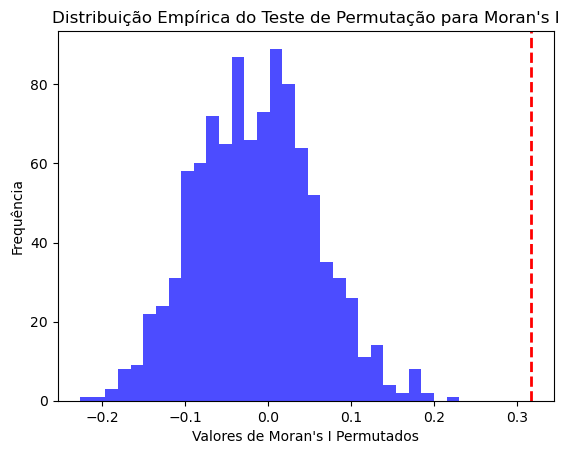

In [255]:
# Visualizar a distribuição empírica
plt.hist(I_permutados_obs, bins=30, alpha=0.7, color='blue')
plt.axvline(moran_val_cs, color='red', linestyle='dashed', linewidth=2)
plt.title("Distribuição Empírica do Teste de Permutação para Moran's I")
plt.xlabel("Valores de Moran's I Permutados")
plt.ylabel("Frequência")
plt.show()

**Análise:**

O histograma mostra a distribuição dos valores de Moran's I gerados por permutação aleatória, sendo que a linha vermelha representa o Moran's I observado nos dados reais.

Como dito anteriormente, como o valor de Moran's I observado está fora da distribuição, a autocorrelação espacial é estatisticamente significativa.

In [256]:
# Este código não está otimizado para grandes conjuntos de dados pelo que pode demorar algum tempo a executar

# I_permutados_cs_Iobs,I_permutados_cs, I_permutados_pvalue  = permutacao_morans_I(shape_BGRI21_Porto_CircEUlar['HousingPrice_Imputation'], w_rook_shape_BGRI21_Porto_CircEUlar.full()[0], 999)
# I_permutados_cs_Iobs,I_permutados_pvalue

In [257]:
# from pysal.explore import esda
from esda.moran import Moran
from esda.moran import Moran_Local

# https://splot.readthedocs.io/en/latest/api.html
# pysal.viz »» splot [splot.esda] (tem métodos para esda e outras componentes - ver api)
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.esda import plot_moran


In [258]:
moran_REG_Aveiro_rendaHab_WRook = Moran(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], w_rook_shape_REG_Aveiro_rendaHab)
moran_REG_Aveiro_rendaHab_WRook.I, moran_REG_Aveiro_rendaHab_WRook.p_sim

(np.float64(0.33626064604798184), np.float64(0.001))

#### Associação espacial - Local

LISA mede a autocorrelação local e é definido por:
$$
I_i = \frac{(x_i - \bar{x})}{S^2} \sum_j w_{ij} (x_j - \bar{x})
$$

onde:
- $I_i$ é o valor de Moran's I local para a observação $i$.
- $S^2$ é a variância da variável espacial.
- $w_{ij}$ é o peso espacial entre a observação $i$ e seus vizinhos $j$.


**Interpretação de Moran's I:**
- $I > 0$ indica autocorrelação espacial positiva (valores similares próximos).
- $I < 0$ indica autocorrelação espacial negativa (valores dissimilares próximos).
- $I \approx 0$ indica ausência de autocorrelação espacial.

Cada observação possui um valor LISA próprio, permitindo analisar padrões espaciais locais.


Interpretar os valores LISA:
   - **Alto-Alto (AA)**: valores elevados cercados por valores elevados.
   - **Baixo-Baixo (BB)**: valores baixos cercados por valores baixos.
   - **Alto-Baixo (AB)**: valores altos cercados por valores baixos.
   - **Baixo-Alto (BA)**: valores baixos cercados por valores altos.

In [259]:
# Função para calcular LISA
def lisa_local(valores, matriz_pesos):
    n = len(valores)
    media_valores = np.mean(valores)
    desvios = valores - media_valores
    W_soma = matriz_pesos.sum(axis=1)
    lisa_I = np.array([(n / W_soma[i]) * (desvios[i] * np.sum(matriz_pesos[i, :] * desvios)) for i in range(n)])
    return lisa_I

In [260]:
lisa_valores = lisa_local(valores, matriz_pesos)

#### Inferência

Os testes de permutação avaliam a significância estatística dos índices espaciais ao compará-los a distribuições empíricas geradas a partir de permutações aleatórias dos dados.

**Hipóteses dos Testes de Permutação - LISA**
- **Hipótese nula ($H_0$)**: O valor observado na localização $i$ não tem correlação espacial com seus vizinhos.
- **Hipótese alternativa ($H_1$)**: O valor na localização $i$ está correlacionado espacialmente com os vizinhos.

In [261]:
def permutacao_lisa(valores, matriz_pesos, num_permutacoes=999):
    lisa_obs = lisa_local(valores, matriz_pesos)
    N = len(valores)
    permutados = np.zeros((num_permutacoes, N))
    for p in range(num_permutacoes):
        valores_perm = np.random.permutation(valores)
        permutados[p] = lisa_local(valores_perm, matriz_pesos)
    p_valores = np.mean(np.abs(permutados) >= np.abs(lisa_obs), axis=0)
    return lisa_obs, p_valores

##### Usando a biblioteca PySAL

In [262]:
# calculate Moran_Local and plot
moranLocal_REG_Aveiro_rendaHab_WRook = Moran_Local(shape_REG_Aveiro_rendaHab['ValMed_RendaMen'], w_rook_shape_REG_Aveiro_rendaHab)

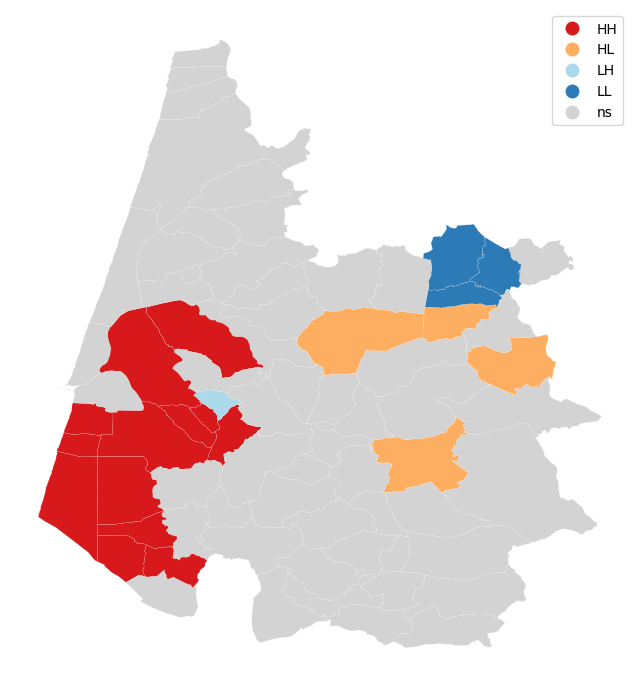

In [263]:
lisa_cluster(moranLocal_REG_Aveiro_rendaHab_WRook, shape_REG_Aveiro_rendaHab, p=0.05, figsize = (8,9))
plt.show()

O mapa apresenta a análise LISA das rendas habitacionais, que torna possível identificar clusters espaciais relevantes para a análise exploratória dos dados.

A distribuição espacial das rendas sugere que existe desigualdade territorial, com áreas valorizadas próximas entre si e zonas com rendas de valores mais baixos, a saber:

*   AA (HH, vermelho): Freguesias com rendas elevadas rodeadas por outras igualmente altas. Esta concentração está ao centro da região, associada a melhores infraestruturas, serviços e à proximidade ao litoral.
*   BB (LL, azul escuro): Áreas com rendas baixas cercadas por outras também baixas, localizadas no interior. Este padrão reflete menor procura imobiliária e menor dinamismo económico.
*   AB (HL, laranja): Refere-se a freguesias com rendas elevadas, rodeadas por áreas com rendas mais baixas. Exemplos incluem Águeda e Albergaria-a-Velha, que são influenciadas pela existência de zonas industriais, que consequentemente, tem impacto na valorização imobiliária dessas freguesias.
*   BA (LH, azul escuro): Existe apenas uma freguesia na região de Aveiro nesta categoria. Apresenta-se com rendas baixas, cercada por áreas de rendas altas, e normalmente representa zonas de transição ou de crescimento.
*   ns (Não significativo, cinzento): Regiões sem padrão estatisticamente significativo.

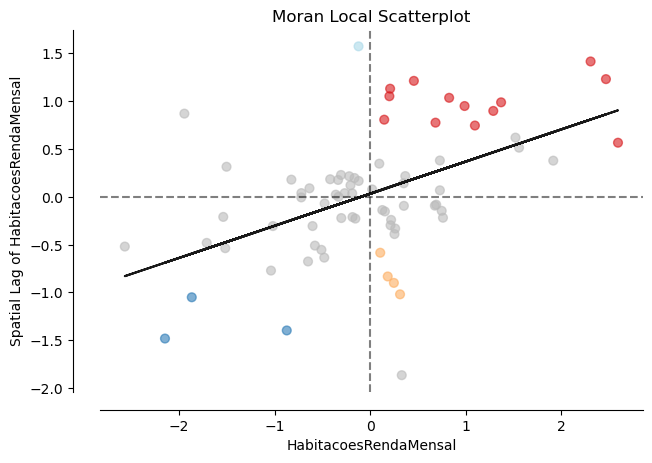

In [264]:
figura, ax = moran_scatterplot(moranLocal_REG_Aveiro_rendaHab_WRook, p=0.05)
ax.set_xlabel('HabitacoesRendaMensal')
ax.set_ylabel('Spatial Lag of HabitacoesRendaMensal')
plt.show()

Alinhado com a análise LISA, conseguimos também perceber através deste scatterplot as aglomerações de freguesias com valores semelhantes.

No **quadrante superior direito (AA)** estão representadas as unidades com valores mais altos e rodeadas por outras com valores parecidos. Enquanto que no **quadrante oposto (BB)**, temos um cluster de freguesias com valores baixos de renda vizinhos de outras com valores semelhantes.

Os outliers positivos presentes no **quadrante inferior direito (AB)** tem valores altos cercados por valores baixos, destacando-se da maioria das áreas ao redor.

O restante, que compõe a maioria da região, está distribuído de forma mais homogénea, sem uma clara tendência para valores altos ou baixos.

## Análise de preços de habitação à escala local

### Pré-processamento dos dados

#### Base de Dados do mercado de habitação de Aveiro

#### Combinar informação espacial

### Análise exploratória de dados e pré-processamento

#### Variáveis contínuas

##### Variável dependente (Preço)

Páragrafo a acrescentar

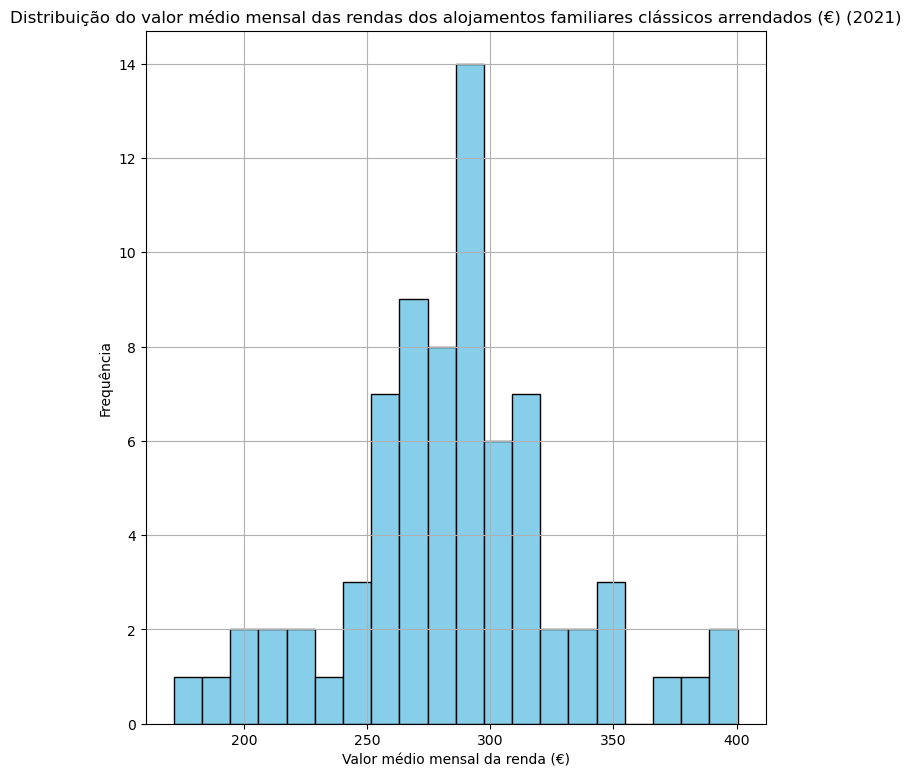

In [265]:
valores_renda = shape_REG_Aveiro_rendaHab['ValMed_RendaMen']

# Criar o histograma
fig, ax = plt.subplots(1, figsize=(8, 9))
ax.hist(valores_renda, bins=20, color='skyblue', edgecolor='black')

# Ajustes adicionais no gráfico
ax.set_title('Distribuição do valor médio mensal das rendas dos alojamentos familiares clássicos arrendados (€) (2021)')
ax.set_xlabel('Valor médio mensal da renda (€)')
ax.set_ylabel('Frequência')
plt.grid(True)

# Exibir o histograma
plt.show()



##### Variável independente (distância ao litoral)

In [266]:
# Carregar shapefile das freguesias de Aveiro
freguesias = shape_REG_Aveiro_rendaHab

# Lista de freguesias litorâneas (exemplo - ajuste conforme seus dados)
litoral_codigos = [
    "010511",  # São Jacinto (Aveiro)
    "011006",  # Gafanha da Nazaré
    "011005",  # Gafanha da Encarnação
    "011804",  # Gafanha da Boa Hora
    "011007",  # Gafanha do Carmo
    "011204",  # Torreira (Murtosa)
    "011502",  # Cortegaça
    "011504",  # Cortegaça
    "011503",  # Esmoriz
    "011509"   # Ovar
]

# Criar coluna 'litoral' (1 = litoral, 0 = não litoral)
freguesias['litoral'] = freguesias['DTMNFR21'].apply(
    lambda x: 1 if any(nome in x for nome in litoral_codigos) else 0
)

##### Variável independente (distância ao centro)

In [267]:
from shapely.geometry import Point

# Coordenadas do centro de Aveiro (ex.: Praça da República)
centro_aveiro = Point(-8.6538, 40.6412)  # (long, lat)

# Calcular distância ao centro
freguesias['dist_centro'] = freguesias.geometry.centroid.distance(centro_aveiro) * 111  # km

# Classificar como "próximo" se distância <= 10 km
freguesias['proximo_centro'] = (freguesias['dist_centro'] <= 10).astype(int)


/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_21574/4095785144.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  freguesias['dist_centro'] = freguesias.geometry.centroid.distance(centro_aveiro) * 111  # km
/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_21574/4095785144.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  freguesias['dist_centro'] = freguesias.geometry.centroid.distance(centro_aveiro) * 111  # km


##### Distância ao centro & Litoral

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_21574/2505037956.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_21574/2505037956.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


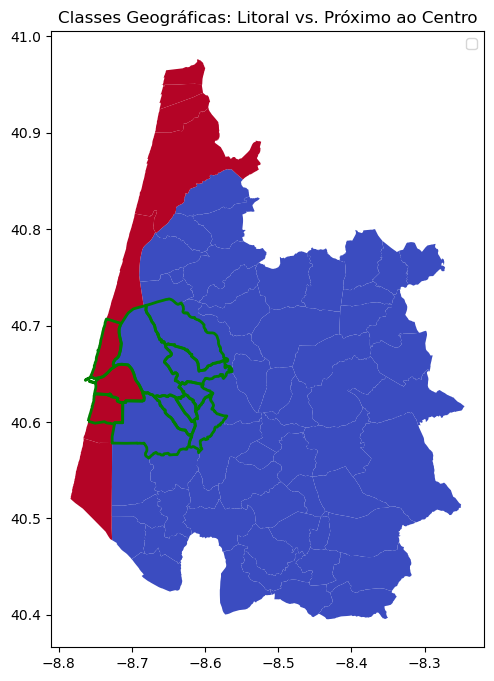

In [268]:
fig, ax = plt.subplots(figsize=(10, 8))
freguesias.plot(
    ax=ax,
    column='litoral',
    legend=True,
    cmap='coolwarm',
    categorical=True,
    legend_kwds={'title': "Zonas Litoral", 'labels': ["Não", "Sim"]}
)
freguesias[freguesias['proximo_centro'] == 1].plot(
    ax=ax,
    color='none',
    edgecolor='green',
    linewidth=2,
    label="Próximo ao Centro"
)
plt.title("Classes Geográficas: Litoral vs. Próximo ao Centro")
plt.legend()
plt.show()

##### Preço das Rendas & Distância ao Litoral

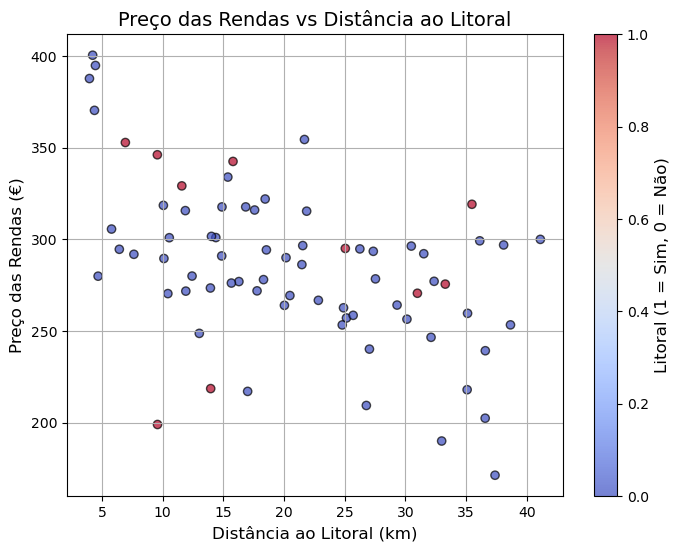

In [269]:
import matplotlib.pyplot as plt

# Preço vs Distância ao Litoral (usando a variável 'litoral' para colorir os pontos)
fig, ax = plt.subplots(1, figsize=(8, 6))

# Criando o gráfico de dispersão, colorindo os pontos conforme a variável 'litoral'
scatter = ax.scatter(freguesias['dist_centro'], freguesias['ValMed_RendaMen'],
                     c=freguesias['litoral'], cmap='coolwarm', edgecolor='black', alpha=0.7)

# Adicionando título e rótulos aos eixos
ax.set_title('Preço das Rendas vs Distância ao Litoral', fontsize=14)
ax.set_xlabel('Distância ao Litoral (km)', fontsize=12)
ax.set_ylabel('Preço das Rendas (€)', fontsize=12)

# Adicionando a barra de cores para indicar o valor da variável 'litoral'
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Litoral (1 = Sim, 0 = Não)', fontsize=12)

# Exibindo a grade
plt.grid(True)

# Mostrar o gráfico
plt.show()



##### Preço das Rendas & Distância ao Centro

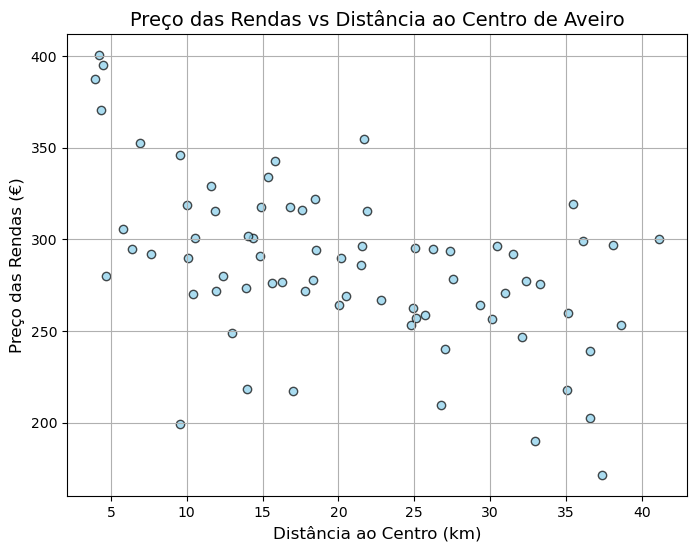

In [270]:
import matplotlib.pyplot as plt

# Preço vs Distância ao Centro
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(freguesias['dist_centro'], freguesias['ValMed_RendaMen'], color='skyblue', edgecolor='black', alpha=0.7)

# Adicionando título e rótulos aos eixos
ax.set_title('Preço das Rendas vs Distância ao Centro de Aveiro', fontsize=14)
ax.set_xlabel('Distância ao Centro (km)', fontsize=12)
ax.set_ylabel('Preço das Rendas (€)', fontsize=12)

# Exibindo a grade
plt.grid(True)

# Mostrar o gráfico
plt.show()


/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_21574/3771758693.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


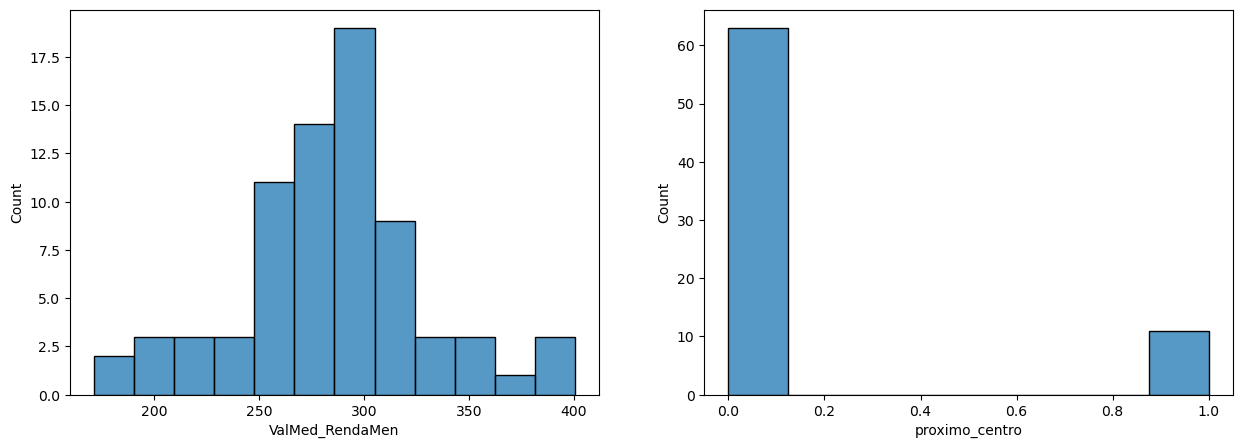

In [271]:
fig, ax =plt.subplots(1,2, figsize=(15, 5))
sns.histplot(data=shape_REG_Aveiro_rendaHab, x="ValMed_RendaMen", ax=ax[0])
sns.histplot(data=freguesias, x="proximo_centro", ax=ax[1])
fig.show()

/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_21574/3667948622.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


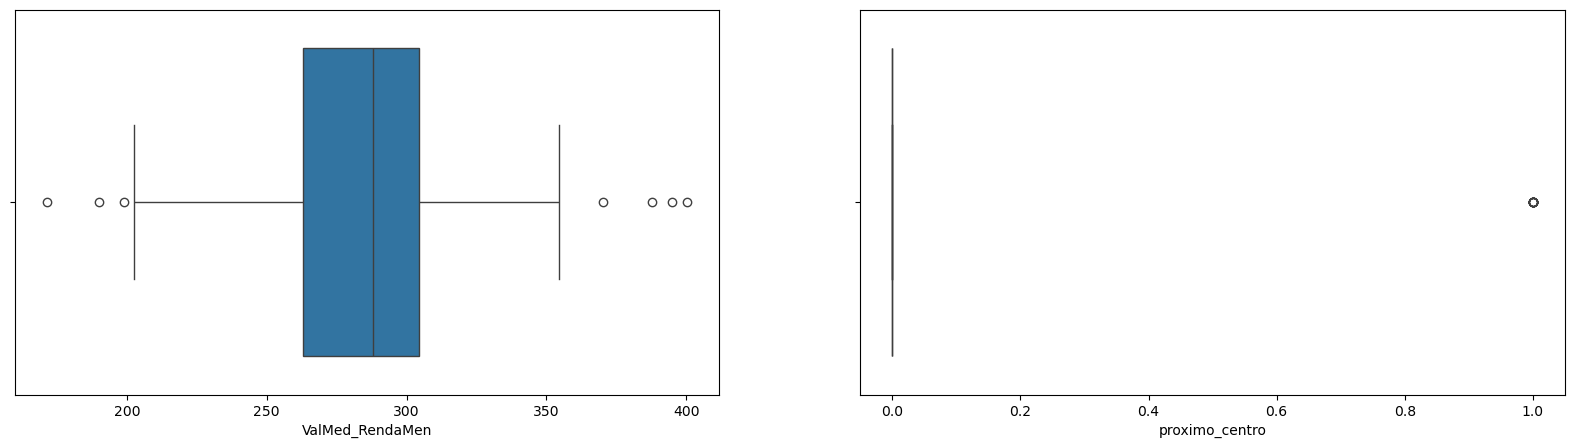

In [272]:
fig, ax =plt.subplots(1,2, figsize=(20, 5))
sns.boxplot(x=shape_REG_Aveiro_rendaHab["ValMed_RendaMen"], ax=ax[0])
sns.boxplot(x=freguesias["proximo_centro"], ax=ax[1])
fig.show()

#### Variáveis categóricas

##### Variável independente - Variável temporal

In [273]:
shape_REG_Aveiro_rendaHab.groupby('proximo_centro')['ValMed_RendaMen'].count()
#shape_REG_Aveiro_rendaHab.groupby('Year')['ID'].count()

proximo_centro
0    63
1    11
Name: ValMed_RendaMen, dtype: int64

### Análise econométrica espacial

O mercado habitacional é um mercado que varia ao longo do tempo, pelo que importa considerar uma estratégia de modelação dos efeitos temporais de acordo com os objetivos da nossa análise e tendo em conta que os dados foram recolhidos ao longo de um período de tempo alargado. Neste caso, uma vez que estamos focados na modelação dos efeitos espaciais (dados em "secção" - "cross-section") podemos fixar os efeitos temporais de uma forma simples, considerando variáveis "dummy" para os períodos de tempo fornecidos (ano).

#### Preparação e Seleção dos dados

In [274]:
shape_REG_Aveiro_rendaHab.columns

Index(['DTMNFR21', 'geometry', 'N_EDIFICIOS_CLASSICOS',
       'N_EDIFICIOS_CLASS_CONST_1_OU_2_ALOJ',
       'N_EDIFICIOS_CLASS_CONST_3_OU_MAIS_ALOJAMENTOS',
       'N_EDIFICIOS_EXCLUSIV_RESID', 'N_EDIFICIOS_1_OU_2_PISOS',
       'N_EDIFICIOS_3_OU_MAIS_PISOS', 'N_EDIFICIOS_CONSTR_ANTES_1945',
       'N_EDIFICIOS_CONSTR_1946_1980', 'N_EDIFICIOS_CONSTR_1981_2000',
       'N_EDIFICIOS_CONSTR_2001_2010', 'N_EDIFICIOS_CONSTR_2011_2021',
       'N_EDIFICIOS_COM_NECESSIDADES_REPARACAO', 'N_ALOJAMENTOS_TOTAL',
       'N_ALOJAMENTOS_FAMILIARES', 'N_ALOJAMENTOS_FAM_CLASS_RHABITUAL',
       'N_ALOJAMENTOS_FAM_CLASS_VAGOS_OU_RESID_SECUNDARIA',
       'N_RHABITUAL_ACESSIVEL_CADEIRAS_RODAS',
       'N_RHABITUAL_COM_ESTACIONAMENTO', 'N_RHABITUAL_PROP_OCUP',
       'N_RHABITUAL_ARRENDADOS', 'N_AGREGADOS_DOMESTICOS_PRIVADOS',
       'N_ADP_1_OU_2_PESSOAS', 'N_ADP_3_OU_MAIS_PESSOAS',
       'N_NUCLEOS_FAMILIARES',
       'N_NUCLEOS_FAMILIARES_COM_FILHOS_TENDO_O_MAIS_NOVO_MENOS_DE_25',
       'N_INDIVIDU

In [283]:
shape_REG_Aveiro_rendaHab.type

0     Polygon
1     Polygon
2     Polygon
3     Polygon
4     Polygon
       ...   
69    Polygon
70    Polygon
71    Polygon
72    Polygon
73    Polygon
Length: 74, dtype: object

In [275]:
select_variables = ['ValMed_RendaMen', 
                    'proximo_centro', 'litoral'
                    ]

In [276]:
shape_REG_Aveiro_rendaHab_modelling = shape_REG_Aveiro_rendaHab[select_variables]

In [277]:
shape_REG_Aveiro_rendaHab_modelling.shape

(74, 3)

#### Matrizes de pesos / vizinhanças

In [278]:
shape_REG_Aveiro_rendaHab_modelling.columns

Index(['ValMed_RendaMen', 'proximo_centro', 'litoral'], dtype='object')

In [279]:
# Criar uma matriz de pesos espaciais baseada na contiguidade (vizinhança)
w = libpysal.weights.Queen.from_dataframe(freguesias)

# Normalizar a matriz de pesos (opcional, depende do modelo)
w.transform = 'r'

# Verificar os pesos
print(w.full()[0])  # Exibe os pesos de todas as vizinhanças


/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_21574/2144376497.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(freguesias)


[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.5  0.  ]
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


In [280]:
# Definir as variáveis independentes (X) e dependentes (y)
X = freguesias[['dist_centro', 'litoral']]
y = freguesias['ValMed_RendaMen']

# Ajustar o modelo de regressão espacial com a matriz de pesos W
modelo = ML_Lag(y, X, w=w, robust=True)

# Exibir o resumo do modelo
print(modelo.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ValMed_RendaMen                Number of Observations:          74
Mean dependent var  :    285.3164                Number of Variables   :           4
S.D. dependent var  :     44.6783                Degrees of Freedom    :          70
Pseudo R-squared    :      0.2792
Spatial Pseudo R-squared:  0.2593
Log likelihood      :   -373.9235
Sigma-square ML     :   1419.7423                Akaike info criterion :     755.847
S.E of regression   :     37.6795                Schwarz criterion     :     765.063

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------

Escolha de um caso para análise detalhada

#### K-Vizinhos mais próximos (KNN)

In [287]:
# Combine as coordenadas X e Y das geometria do shapefile
vector_pnts = np.column_stack([freguesias.geometry.centroid.x, freguesias.geometry.centroid.y])


/var/folders/g2/97p4dxg92h99cr9n1fy4vr400000gn/T/ipykernel_21574/1113846197.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vector_pnts = np.column_stack([freguesias.geometry.centroid.x, freguesias.geometry.centroid.y])


In [288]:
# Calcular os vizinhos mais próximos (4 vizinhos, com raio de 60km)
wk4 = libpysal.cg.brute_knn(vector_pnts, 4, mode='xyz', radius=60000)
wk4 = libpysal.weights.W(wk4)

In [289]:
# Calcular os vizinhos mais próximos com os centroides
wk4 = libpysal.cg.brute_knn(vector_pnts, 4, mode='xyz', radius=60000)
wk4 = libpysal.weights.W(wk4)

In [304]:
import geopandas as gpd
import numpy as np
import libpysal

# Certifique-se de que as 'freguesias' estão no CRS correto (UTM)
freguesias = freguesias.to_crs(epsg=32629)  # Projeção para UTM (freguesias de Aveiro)

# Combine as coordenadas X e Y dos centroides dos polígonos
vector_pnts = np.column_stack([freguesias.geometry.centroid.x, freguesias.geometry.centroid.y])

# Calcular os vizinhos mais próximos (4 vizinhos, com raio de 60 km)
wk4 = libpysal.cg.brute_knn(vector_pnts, 4, mode='xyz', radius=60000)
wk4 = libpysal.weights.W(wk4)

# Row standardization da matriz de pesos (transformação "r")
wk4.transform = 'r'

# Verificar o número de casos
print("»» Número de casos: ", wk4.n)

# Verificar os casos sem vizinhos
print("»» Número de casos sem vizinhos: ", wk4.islands)

# Verificar a densidade da matriz
print("»» Indicador de densidade da matriz: ", wk4.pct_nonzero)

# Corrigir o índice inválido - Vamos usar um índice válido (por exemplo, 0)
index_valid = 0  # Tente com o índice 0 ou outro índice válido (0 a 73)
print(f"»» Vizinhos (referência) para o índice {index_valid}: ", wk4.neighbors[index_valid])

# Pesos atribuídos aos vizinhos do índice válido
print(f"»» Pesos atribuídos aos Vizinhos do índice {index_valid}: ", wk4[index_valid])


»» Número de casos:  74
»» Número de casos sem vizinhos:  []
»» Indicador de densidade da matriz:  5.405405405405405
»» Vizinhos (referência) para o índice 0:  [5, 18, 17, 4]
»» Pesos atribuídos aos Vizinhos do índice 0:  {5: 0.25, 18: 0.25, 17: 0.25, 4: 0.25}


In [305]:
# Calcular o Índice de Moran para a variável dependente 'ValMed_RendaMen'
moran_renda = Moran(freguesias['ValMed_RendaMen'], wk4)
print("Moran's I: ", moran_renda.I)
print("Valor p do teste de Moran: ", moran_renda.p_sim)

Moran's I:  0.2974166199021514
Valor p do teste de Moran:  0.001


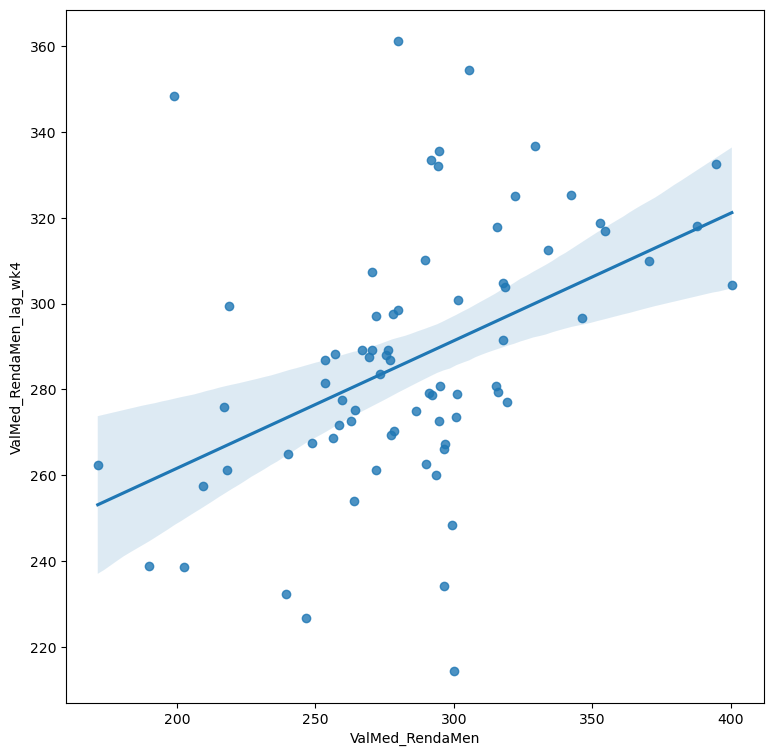

In [306]:
# Calcular o lag espacial para 'ValMed_RendaMen'
freguesias["ValMed_RendaMen_lag_wk4"] = weights.lag_spatial(wk4, freguesias['ValMed_RendaMen'])

# Plotar a relação entre a renda e o seu lag espacial
figura, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x="ValMed_RendaMen", y="ValMed_RendaMen_lag_wk4", data=freguesias)
plt.show()

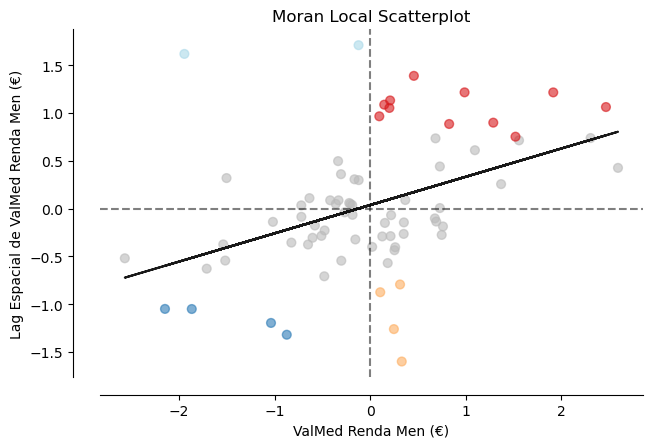

In [293]:
# Calcular o Moran Local (LISA) para a variável dependente
moranLocal_renda = Moran_Local(freguesias['ValMed_RendaMen'], wk4)

# Gerar o gráfico de Moran
figura, ax = moran_scatterplot(moranLocal_renda, p=0.05)
ax.set_xlabel('ValMed Renda Men (€)')
ax.set_ylabel('Lag Espacial de ValMed Renda Men (€)')
plt.show()

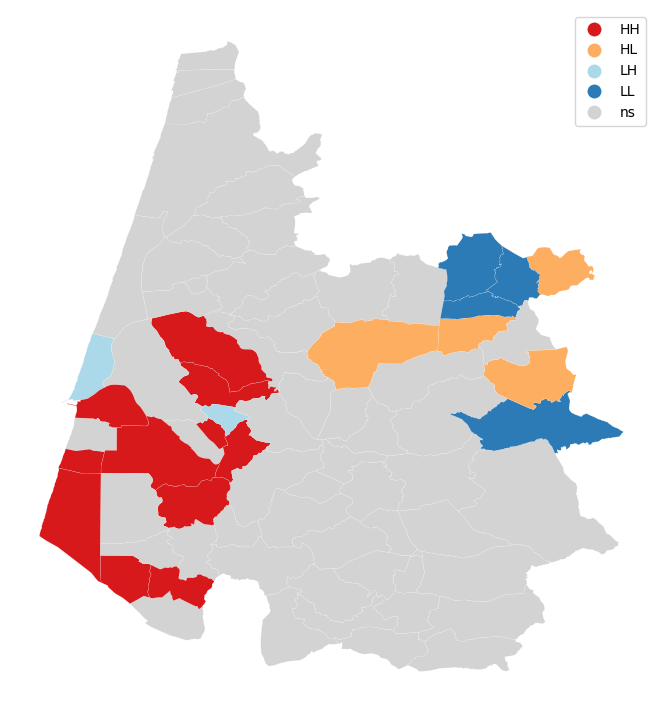

In [294]:
# Gerar o gráfico de LISA Cluster
lisa_cluster(moranLocal_renda, freguesias, p=0.05, figsize=(9, 9))
plt.show()


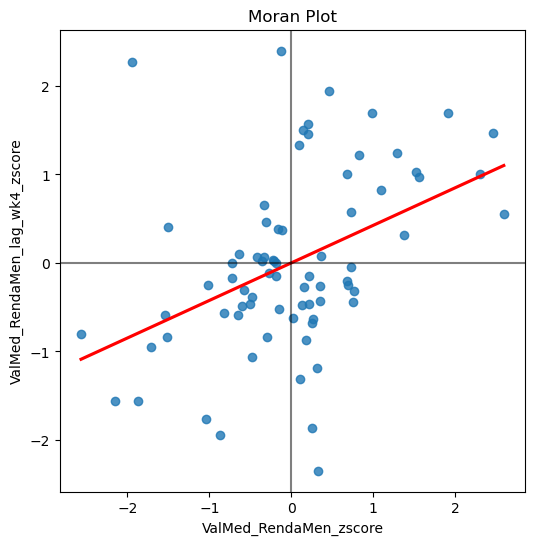

In [295]:
# Normalizar os dados com escore Z
from scipy import stats

freguesias['ValMed_RendaMen_zscore'] = stats.zscore(freguesias['ValMed_RendaMen'])
freguesias['ValMed_RendaMen_lag_wk4_zscore'] = stats.zscore(freguesias['ValMed_RendaMen_lag_wk4'])

# Plotar o gráfico de Moran
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='ValMed_RendaMen_zscore', y='ValMed_RendaMen_lag_wk4_zscore', ci=None, data=freguesias, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot')
plt.show()

#### Polígonos de Voronoi

IMPORTANTE: Neste caso, temos várias habitações (representadas por pontos) que têm exatamente a mesma coordenada geográfica (possível explicação? Habitações no mesmo edifício, como é o caso de um edifício de apartamentos!). Assim, para construir polígonos de voronoi, é necessário adotar uma estratégia indireta. Neste notebook, adota-se a estratégia de i) eliminar os pontos coincidentes ii) calculara os polígonos de voronoi para os pontos distintos iii) atribuir os polígonos de voronoi aos registos originais (ou seja, haverá registos com polígonos coincidentes!). Note-se que esta estratégia é uma simplificação e que poderá não ser a mais adequada para todos os casos. A determinação da matriz de pesos irá considerar os polígonos coincidentes como vizinhos uma vez que a operação decorre por comparação geométrica dos pontos coincidentes de fronteira dos polígonos.

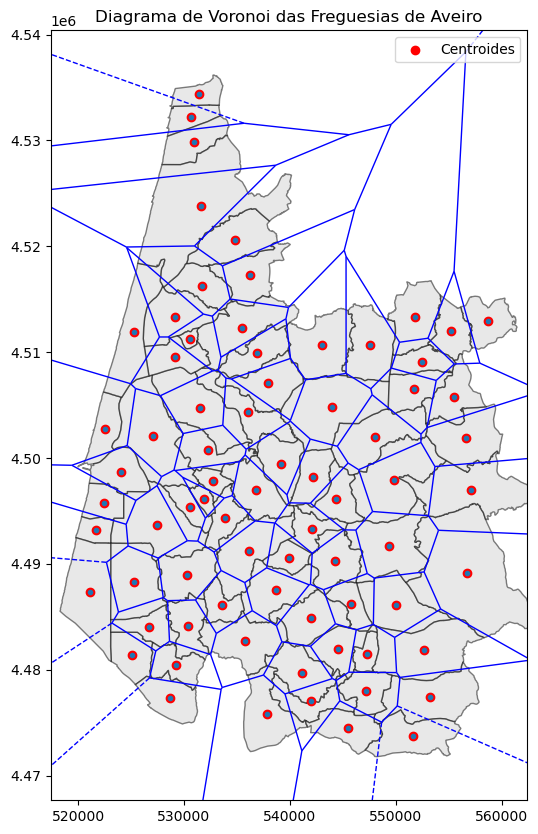

In [366]:
# Projeção UTM
freguesias = freguesias.to_crs(epsg=32629)

# Combine as coordenadas X e Y dos centroides dos polígonos
vector_pnts = np.column_stack([freguesias.geometry.centroid.x, freguesias.geometry.centroid.y])

# Calcular os vizinhos mais próximos (4 vizinhos, com raio de 60 km)
wk4 = libpysal.cg.brute_knn(vector_pnts, 4, mode='xyz', radius=60000)
wk4 = libpysal.weights.W(wk4)

# Row standardization da matriz de pesos (transformação "r")
wk4.transform = 'r'

# Agora, geramos o diagrama de Voronoi para os centroides
vor = Voronoi(vector_pnts)

# Visualizar o diagrama de Voronoi
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar as linhas do Diagrama de Voronoi
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1)

# Plotar as freguesias no mesmo gráfico
freguesias.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Adicionar os centroides como pontos
ax.scatter(freguesias.geometry.centroid.x, freguesias.geometry.centroid.y, color='red', marker='o', label='Centroides')

# Ajustar o título e mostrar
ax.set_title("Diagrama de Voronoi das Freguesias de Aveiro")
ax.legend(loc='best')
plt.show()


### Modelos econométricos espaciais

Como vimos anteriormente, a complexidade da noção de espaço exige a adoção de um conjunto de assunções sobre as características espaciais relevantes para o fenómeno em estudo bem como os efeitos que essa estrutura espacial suporta na relação entre as nossas observações.
Uma das formas de analisar estes efeitos passa por colocarmos o foco num conjunto de efeitos espaciais relacionados com a *configuração espacial* do nosso objeto de estudo / unidade de análise.

No exemplo que temos vindo a trabalhar, estes efeitos são facilmente identificados como parte de fenómenos amplamente reconhecidos: por exemplo, podemos facilmente colocar como hipótese que o preço de uma habitação não
para só depende das suas características físicas (como a sua área, se é uma moradia ou um apartamento, nova ou usada, etc), mas também poderá depender das características físicas das habitações que se encontram nas suas proximidades; uma moradia no meio de apartamentos em arranha-céus nas redondezas ou uma moradia no meio de um conjunto de moradias semelhantes será expectável que estas duas habitações (mantendo tudo o resto constante) tenham um associação com as habitações que as rodeiam.
Que forma poderá tomar essa associação? Pode, na verdade, estar associado a fenómenos espaciais ligeiramente diferenciados, por exemplo um efeito associado à localização da habitação e das suas vizinhas, formando conjunto com a) características físicas observadas (as variáveis explicativas do preço da habitação), b) um efeito associado à partilha de um determinado "ambiente urbano" e das habitações aí localizadas. 

Nos efeitos de **dependência espacial** os efeitos relacionam-se fundamentalmente com as características das nossas observações (objeto de estudo) e ao seu arranjo espacial particular.

Quatro modelos principais:
1. **Modelo de Desfasagem Espacial (SLM)**  
2. **Modelo de Erro Espacial (SEM)**  
3. **Modelo de Durbin Espacial (SDM)**  
4. **Modelo de Desfasagem e Erro Espacial (SLEM)**  

**Modelo de Defasagem Espacial (SLM)**

O Modelo de Defasagem Espacial introduz dependência espacial diretamente na variável dependente. O modelo é expresso como:

$$ Y = \rho WY + X\beta + \varepsilon $$

Onde:  
- $Y$: vetor das variáveis dependentes.  
- $W$: matriz de pesos espaciais, indicando a estrutura de dependência espacial.  
- $\rho$: coeficiente autorregressivo espacial.  
- $X$: matriz das variáveis explicativas.  
- $\beta$: vetor dos coeficientes.  
- $\varepsilon$: termo de erro.

**Mecanismo:** O termo $WY$ significa que a variável dependente em um local depende das variáveis dependentes das regiões vizinhas.

**Derivação dos Efeitos Diretos, Indiretos e Totais**

$$
Y = (I - \rho W)^{-1} X \beta + (I - \rho W)^{-1} \varepsilon
$$

Derivada parcial de $Y$ em relação a $X$:

$$
\frac{\partial Y}{\partial X} = (I - \rho W)^{-1} \beta
$$

- **Efeito Direto:** Diagonal de $(I - \rho W)^{-1} \beta$.  
- **Efeito Indireto:** Soma das componentes fora da diagonal.  
- **Efeito Total:** Soma de todos os efeitos diretos e indiretos.

---

**Modelo de Erro Espacial (SEM)**

$$
Y = X \beta + \varepsilon \quad \text{com} \quad \varepsilon = \lambda W \varepsilon + \mu
$$

- $\lambda$: coeficiente autorregressivo nos erros.  
- $\mu$: erro aleatório normal.

**Mecanismo:** A dependência espacial é modelada nos erros.

Derivada:  

$$
Y = X \beta + (I - \lambda W)^{-1} \mu
$$

---

**Modelo de Durbin Espacial (SDM)**

$$
Y = \rho W Y + X \beta + W X \theta + \varepsilon
$$

**Derivação dos Efeitos**

$$
E[Y] = (I - \rho W)^{-1} (X \beta + W X \theta)
$$

$$
\frac{\partial E[Y]}{\partial X} = (I - \rho W)^{-1} (\beta + W \theta)
$$

- **Efeito Direto:** Diagonal.  
- **Efeito Indireto:** Soma fora da diagonal.  
- **Efeito Total:** Soma dos dois.

---

**Modelo de Defasagem e Erro Espacial (SLEM)**

$$
Y = \rho W Y + X \beta + \varepsilon \quad \text{com} \quad \varepsilon = \lambda W \varepsilon + \mu
$$

**Derivação dos Efeitos**

$$
Y = (I - \rho W)^{-1} X \beta + (I - \rho W)^{-1} (I - \lambda W)^{-1} \mu
$$

- **Efeito Direto:** Diagonal de $(I - \rho W)^{-1} \beta$.  
- **Efeito Indireto:** Fora da diagonal.



#### M0: Modelo Base (não espacial)

Antes de discutirmos como incluir explicitamente o espaço na estrutura de regressão linear, vamos construir um modelo de regressão básico.
A ideia central da regressão linear é explicar a variação em uma determinada variável (*a explicar* / *dependente*) como uma função linear de uma coleção de outras variáveis (*explicativas* / *independentes*). 
No exemplo aqui trabalhado queremos expressar / explicar o preço de uma casa em função de um conjunto de variáveis explicativas como seja a área, o tipo (aparamento ou moradia) a categoria de preservação e um conunto de outras características de qualidade e conforto assinaladas.
Podemos expressar o nosso modelo como:

$$
P_i = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

onde $P_i$ é o preço por m2 da habitaçao anunuciado, $i$, and $X$ é o conjunto de variáveis que selecionamos como candidatas a variáveis explicativas do referido preço. $\beta$ é o conjunto de parâmetros que nos indicam como e com que extensão cada uma das variáveis explicativas selecionadas está relacionada (em média) com os preços da habitação (numa expecificação simples podem ser interpretados como o "preço" (preço hedónico) específico do referido atributo da habitação). $\alpha$, é um termo constante que nos indica o valor (médio) da variável dependente quando todas as outras variáveis são iguais a zero (o que, numa interpretação simples para um modelo com especificação simples no nosso caso de estudo poderá ser interpretado como o preço do terreno da habitação). O termo $\epsilon_i$ é usualmente referido como  "erro" e captura os elementos que influenciam a variável a explicar mas que não foram incluídas como variáveis explicativas $X$. 

Podemos ainda expressar este modelo na forma matricial, excluindo os índices $i$ correspondentes à observação individual: 

$$
P = \alpha + \mathbf{X}\beta + \epsilon
$$

###### M0a - Diagnóstico estatístico "standard"

In [432]:
from spreg import OLS

# Criar coluna 'litoral' (1 = litoral, 0 = não litoral)
freguesias['litoral'] = freguesias['DTMNFR21'].apply(
    lambda x: 1 if any(nome in x for nome in litoral_codigos) else 0
)

# Variável dependente: Renda média
y = freguesias['ValMed_RendaMen'].astype(float).values.reshape((-1, 1))

# Variáveis independentes: Distância ao centro e litoral
X = freguesias[['dist_centro', 'litoral']].astype(float).values

# Passo 2: Ajustar o modelo OLS (Modelo base não espacial)
M0a = OLS(y, X, name_y='preço', name_x=['dist_centro', 'litoral'])

# Passo 3: Exibir os resultados do modelo
print(M0a.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       preço                Number of Observations:          74
Mean dependent var  :    285.3164                Number of Variables   :           3
S.D. dependent var  :     44.6783                Degrees of Freedom    :          71
R-squared           :      0.2567
Adjusted R-squared  :      0.2358
Sum squared residual:      108314                F-statistic           :     12.2592
Sigma-square        :    1525.555                Prob(F-statistic)     :    2.67e-05
S.E. of regression  :      39.058                Log likelihood        :    -374.684
Sigma-square ML     :    1463.709                Akaike info criterion :     755.369
S.E of regression ML:     38.2584                Schwarz criterion     :     762.281

------------------------------------------------------------

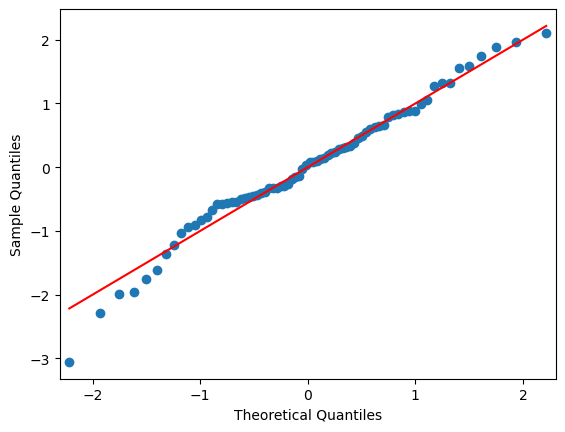

In [328]:
# Acessando os resíduos do modelo OLS
residuos = M0a.u[:, 0]

# Gerar o gráfico QQ plot para verificar a normalidade dos resíduos
sm.qqplot(residuos, line='s', fit=True)

# Exibir o gráfico
plt.show()


In [433]:
x = sm.add_constant(X)

model = sm.OLS(y, X)

results = model.fit()

# Exibir o resumo do modelo
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.741
Model:                            OLS   Adj. R-squared (uncentered):              0.733
Method:                 Least Squares   F-statistic:                              102.8
Date:                Tue, 01 Apr 2025   Prob (F-statistic):                    7.95e-22
Time:                        22:54:48   Log-Likelihood:                         -474.32
No. Observations:                  74   AIC:                                      952.6
Df Residuals:                      72   BIC:                                      957.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [362]:
# Ajuste do modelo
OLS_sm_mod_fit_results = model.fit()

# Exibir o resumo do modelo
print(OLS_sm_mod_fit_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     12.26
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           2.67e-05
Time:                        22:14:12   Log-Likelihood:                -374.68
No. Observations:                  74   AIC:                             755.4
Df Residuals:                      71   BIC:                             762.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        329.3780     10.533     31.272      0.0

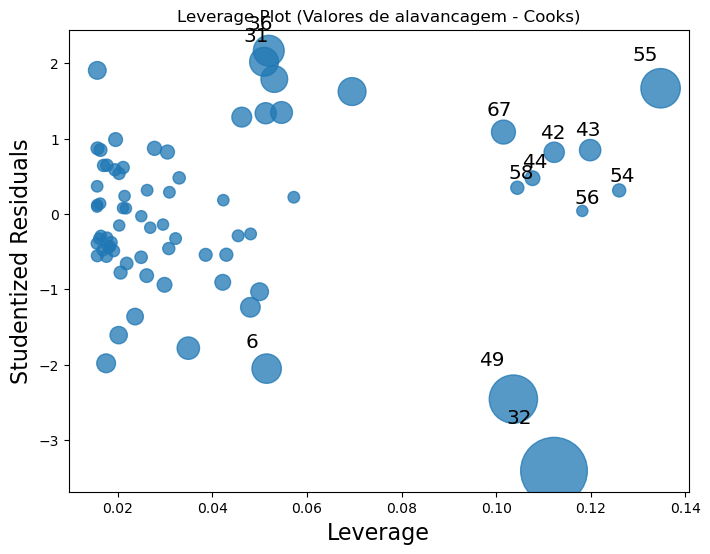

In [363]:
#Leverage Plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.influence_plot(OLS_sm_mod_fit_results, ax=ax, criterion="cooks") 
ax.set_title("Leverage Plot (Valores de alavancagem - Cooks)")
plt.show()

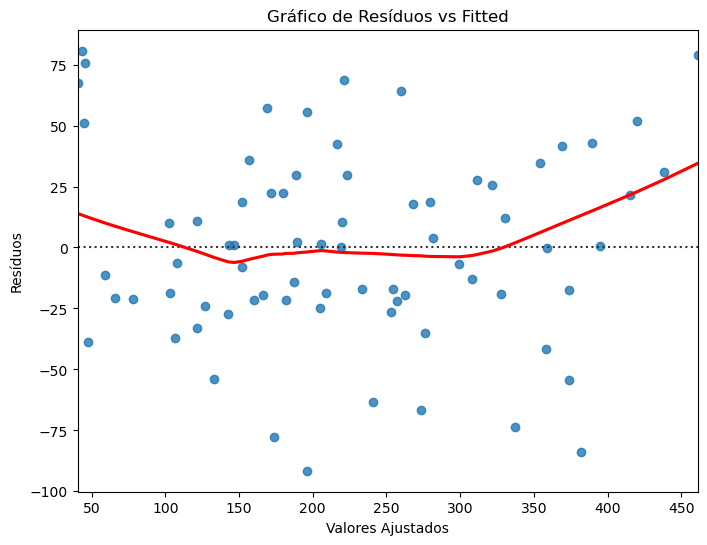

In [342]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.residplot(x=results.fittedvalues, y=results.resid, lowess=True, line_kws={'color': 'red'}, ax=ax)
ax.set_title("Gráfico de Resíduos vs Fitted")
ax.set_xlabel("Valores Ajustados")
ax.set_ylabel("Resíduos")
plt.show()

classic t-test

H0: Dist1 = Dist2 vs H1: Dist1 =/= Dist2 

Decision:
pvalue < 0,05 -> Reject H0

stats.ttest_ind(rural, not_rural)

###### M0b

In [367]:
M0b = OLS(
    y,  # Variável dependente
    x,  # Variáveis independentes
    name_y='ValMed_RendaMen',  # Nome da variável dependente
    name_x=['const', 'dist_centro', 'litoral'],  # Nomes das variáveis independentes
    w=wk4,  # Matriz de pesos espaciais
    spat_diag=True  # Diagnóstico espacial
)

In [368]:
print(M0b.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ValMed_RendaMen                Number of Observations:          74
Mean dependent var  :    285.3164                Number of Variables   :           3
S.D. dependent var  :     44.6783                Degrees of Freedom    :          71
R-squared           :      0.2567
Adjusted R-squared  :      0.2358
Sum squared residual:      108314                F-statistic           :     12.2592
Sigma-square        :    1525.555                Prob(F-statistic)     :    2.67e-05
S.E. of regression  :      39.058                Log likelihood        :    -374.684
Sigma-square ML     :    1463.709                Akaike info criterion :     755.369
S.E of regression ML:     38.2584                Schwarz criterion     :     762.281

---------------------------------------------------------

Mas como **escolher a especificação / modelo** para incorporar relações de dependência espacial no nosso modelo? 
Os dois mecanismos principais são:
- Dependência **no valor da variável dependente** $\rightarrow$ modelo com lag espacial (SAR).
- Dependência **nos erros** $\rightarrow$ modelo com erro espacial (SEM).

Para nos ajudar no processo de decisão, além da teoria, podemos socorrer-nos de dois testes estatísticos fundamentais:
- **Testes de Multiplicadores de Lagrange (LM)**.
- **Testes de Razão de Verosimilhanças (LR)**.

---

**O Desafio da Especificação de Modelos em Econometria Espacial**

Ao escolher um modelo econométrico espacial, é importante determinar se existe dependência espacial nos dados. Modelos incorretamente especificados resultam em estimadores ineficientes, viesados ou inconsistentes.

Exemplos:
1. **Modelo com Lag Espacial na variável Y**:

$$
y = \rho W y + X\beta + \varepsilon
$$

2. **Modelo de erro (SEM)**:

$$
y = X\beta + u, \quad u = \lambda W u + \varepsilon
$$

---

**Testes de Multiplicadores de Lagrange (LM)**

Os **testes LM** servem como diagnóstico inicial para indicar se há dependência espacial. Baseiam-se no **gradiente** da função de log-verosimilhança sob a hipótese nula.

**Ideia Geral:**
- Estima-se o modelo **OLS clássico**, sem efeitos espaciais.
- Com base nos resíduos $e$, calcula-se o LM.

**LM para Lag Espacial (SAR/SLM)**

- **Hipótese Nula**: $H_0: \rho = 0$
- **Hipótese Alternativa**: $H_1: \rho \neq 0$

**Estatística LM Lag**:

$$
LM_{\text{lag}} = \frac{ \left( e' W y / \sigma^2 \right)^2 }{ tr(W'W + W W') }
$$

- $e = y - X\hat{\beta}$: resíduos do OLS.
- $\sigma^2 = \dfrac{e'e}{n}$: variância dos resíduos.

**LM para Erro Espacial (SEM)**

- **Hipótese Nula**: $H_0: \lambda = 0$
- **Hipótese Alternativa**: $H_1: \lambda \neq 0$

**Estatística LM Error**:

$$
LM_{\text{error}} = \frac{ \left( e' W e / \sigma^2 \right)^2 }{ tr(W'W + W W') }
$$

Ambos os testes seguem uma distribuição qui-quadrado com 1 grau de liberdade:

$$
LM \sim \chi^2(1)
$$

**Testes LM Robustos**
Se ambos os LM clássicos forem significativos, utiliza-se as versões robustas para distinguir entre SAR e SEM.

- **Robusto LM Lag**:

$$
RLM_{\text{lag}} = \frac{LM_{\text{lag}}}{1 - \dfrac{tr(W W + W' W)}{n}}
$$

- **Robusto LM Error**:

$$
RLM_{\text{error}} = \frac{LM_{\text{error}}}{1 - \dfrac{tr(W W + W' W)}{n}}
$$

---

**Testes de Razão de Verosimilhanças (LR)**

Os **testes de razão de verosimilhanças (LR)** comparam modelos **aninhados** através das suas **log-verosimilhanças**.

Ideia Geral:
- Estima-se o **modelo restrito** (por exemplo, OLS).
- Estima-se o **modelo irrestrito** (por exemplo, SAR ou SEM).
- Compara-se as **log-verosimilhanças**.

**Estatística LR**:

$$
LR = 2 \left( \ln L_{irrestrito} - \ln L_{restrito} \right)
$$

Segue uma distribuição qui-quadrado com $k$ graus de liberdade, onde $k$ é a diferença no número de parâmetros estimados entre os modelos.

**Exemplo:**
- Comparar OLS (restrito) e SAR (irrestrito):
  - $k = 1$ (parâmetro $\rho$).

---

**Procedimento Formal de Testes de Hipóteses**

| **Passo**              | **Descrição**                                         |
|------------------------|-------------------------------------------------------|
| **1. Hipóteses**       | $H_0$: sem dependência espacial; $H_1$: com efeito espacial |
| **2. Estatística**     | LM ou LR                                              |
| **3. Distribuição**    | $\chi^2(1)$ (ou $\chi^2(k)$)                         |
| **4. Regra de Decisão**| Rejeitar $H_0$ se estatística $>$ $\chi^2_{\alpha, 1}$ |
| **5. Conclusão**       | Rejeitar $H_0$: incluir efeitos espaciais            |

---

**4. Exemplo de Aplicação (Passo-a-Passo)**

**Objetivo: Escolher entre SAR e SEM**
1. Estimar **OLS**:

$$
y = X\hat{\beta}_{OLS} + e
$$

2. Calcular os **LM tests**:
   - $LM_{\text{lag}}$ e $LM_{\text{error}}$.
3. Se ambos forem significativos:
   - Calcular **Robustos LM**:
     - Se apenas o robusto **lag** for significativo $\rightarrow$ SAR.
     - Se apenas o robusto **error** for significativo $\rightarrow$ SEM.
4. Estimar o modelo escolhido (SAR ou SEM).
5. Comparar modelos mais complexos com **LR tests** (ex: SDM).

---

**Fundamento Matemático**

| **Testes LM** | Baseados nas **derivadas primeiras** (gradientes) da log-verosimilhança sob $H_0$. Rápidos, não exigem re-estimar modelos. |
|---------------|-----------------------------------------------------------------------------------------------------------------------------|
| **Testes LR** | Baseados nas **log-verosimilhanças** de modelos aninhados. Exigem estimativas completas dos modelos.                        |

---

**Quando Usar Cada Teste?**

| **Teste**           | **Objetivo**                            | **Melhor Uso**                      |
|---------------------|----------------------------------------|------------------------------------|
| **LM**              | Detecção inicial de autocorrelação     | Diagnóstico a partir de OLS        |
| **LM Robusto**      | Diferenciar dependência lag vs. erro   | Quando ambos LM forem significativos |
| **LR**              | Comparação formal entre modelos        | Após estimação dos modelos espaciais |

---

#### Modelo SLX

A nossa árvore de decisão, embora seja fundamentalmente guiada por um critério estatístico, leva-nos a uma primeira especificação que tem uma interpretação concreta no caso de estudo que estamos a trabalhar.

Com efeito o modelo SLX pode ser interpretado como uma especificação adequada para modelar um mercado habitacional onde prevalecem critérios de procura de casa que tendem a priviligiar a escolha de habitações que se encontram rodeadas (em termos espaciais) de habitações com caracaterísticas (físicas) semelhantes; por exemplo habitações com área maior ao redor da habitação preferida; ou seja, para duas habitações iguais, seria possível identificar que vários intervenientes no mercado que procuram habitação estariam dispostos a pagar mais por uma casa cercada por certos tipos de casas, e menos se fosse localizada no meio de outros tipos de habitação.

A forma como este fenómeno de dependência espacial pode ser introduzido num modelo explicativo dos preços da habitação passa por não só considerar os atributos da habitação em si mas também um seu "desfasamento espacial" (**spatial lag**). Formalmente, tal pode ser expresso como:

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

onde $\sum_{j=1}^N w_{ij}x_{jk}$ representa um desfasamento espacial da $k$th variável independente (explicativa).

Na forma *matricial*, por forma a incluir explicitamente $\mathbf{W}$ temos:
$$
\log(P_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

Esta especificação incorpora assim no  modelo dois tipos de efeitos: $\beta$ and $\gamma$. 
O efeito capturado em $\beta$ descrebe as mudanças induzidas em $y_i$ quando $X_{ik}$ sofre um efeito de uma unidade. [No caso concreto do exemplo em analise, uma vez que transformamos a nossa variável dependente  $y$ com a função logaritmo, os coeficientes $\beta$ podem ser interpretados com base no conceito de *elasticidade*, significando assim que uma mudança de uma unidade na variável  $x_i$ resultará numa $\beta$ mudança percentual no preço *y_i*]. 

O índice para a localização espacial, $i$ , é importante: estabelece exatamente onde (localização) é que o efeito de dependência espacial (definido pela matriz $\mathbf{W}$ ) ocorre. 
O mesmo ocorre para o efeito capturado (a estimar) pelo parâmetro $\gamma$ , que é interpretado como um efeito *indireto* de uma mudança em $X_i$. 

Estes efeitos podem ser conceptualizados de duas maneiras. Em primeiro lugar, podemos pensar em $\gamma$ simplesmente como *o efeito que uma mudança de unidade na variável $X_i$ estabelece na valorização de um ambiente de vizinhança "médio"* . No entanto, esta interpretação ignora o local efetivo onde esta mudança pode ocorrer. Na verdade, uma mudança em uma variável na localização $i$ resultará num contágio para a sua vizinhança em concreto. Ou seja, quando $x_i$ muda, também muda o *desfasamento espacial* de qualquer observação considerada espacialmente vizinha de $i$. O alcance (espacial) dessa mudança é guiado pelo definido na estrutura $\mathbf{W}$. Por exemplo, se pensarmos num local onde as habitações estão altamente conectadas (por exemplo um local de ocupação densa, como o centro?), uma alteração numa dada observação / localização terá um efeito (médio) menos relevante. Numa observação / localização com apenas um vizinho o efeito será  *exatamente* proporcional à quantidade de mudanças no único vizinho. Para descobrir o efeito indireto exato de uma mudança em $y$ causada pela mudança de $x_i$ numa observação / localização em particular temos de incluir então o desfasamento espacial associado à mudança em $X$. 


In [409]:
# LM Lag Test: Teste de Multiplicador de Lagrange para Lag Espacial
print("LM Lag Test:", M0b.lm_lag)

# LM Error Test: Teste de Multiplicador de Lagrange para Erro Espacial
print("LM Error Test:", M0b.lm_error)

LM Lag Test: (np.float64(0.35474401348933376), np.float64(0.5514398663039952))
LM Error Test: (np.float64(0.07337923252267685), np.float64(0.7864787022941506))


In [475]:
from spreg import OLS, ML_Lag, ML_Error, GM_Lag, GM_Error

# Modelo SLX (Spatial Lag of X)
M_SLX = OLS(y, X, w=w, spat_diag=True, name_y='ValMed_RendaMen', name_x=['dist_centro', 'litoral'])
print("### Modelo SLX ###")
print(M_SLX.summary)


### Modelo SLX ###
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ValMed_RendaMen                Number of Observations:          74
Mean dependent var  :    285.3164                Number of Variables   :           3
S.D. dependent var  :     44.6783                Degrees of Freedom    :          71
R-squared           :      0.2567
Adjusted R-squared  :      0.2358
Sum squared residual:      108314                F-statistic           :     12.2592
Sigma-square        :    1525.555                Prob(F-statistic)     :    2.67e-05
S.E. of regression  :      39.058                Log likelihood        :    -374.684
Sigma-square ML     :    1463.709                Akaike info criterion :     755.369
S.E of regression ML:     38.2584                Schwarz criterion     :     762.281

--------------------------------------

#### Modelo SDM

In [470]:
# Modelo SDM (Spatial Durbin Model)
M_SDM = ML_Lag(y, X, w=w, lag_q=True, name_y='ValMed_RendaMen', name_x=['dist_centro', 'litoral'])
print("### Modelo SDM ###")
print(M_SDM.summary)

### Modelo SDM ###
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ValMed_RendaMen                Number of Observations:          74
Mean dependent var  :    285.3164                Number of Variables   :           4
S.D. dependent var  :     44.6783                Degrees of Freedom    :          70
Pseudo R-squared    :      0.2792
Spatial Pseudo R-squared:  0.2593
Log likelihood      :   -373.9235
Sigma-square ML     :   1419.7423                Akaike info criterion :     755.847
S.E of regression   :     37.6795                Schwarz criterion     :     765.063

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------

#### Modelo SEM

In [471]:
# Modelo SEM (Spatial Error Model)
M_SEM = ML_Error(y, X, w=w, name_y='ValMed_RendaMen', name_x=['dist_centro', 'litoral'])
print("### Modelo SEM ###")
print(M_SEM.summary)

### Modelo SEM ###
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ValMed_RendaMen                Number of Observations:          74
Mean dependent var  :    285.3164                Number of Variables   :           3
S.D. dependent var  :     44.6783                Degrees of Freedom    :          71
Pseudo R-squared    :      0.2560
Log likelihood      :   -374.0456
Sigma-square ML     :   1425.9702                Akaike info criterion :     754.091
S.E of regression   :     37.7620                Schwarz criterion     :     761.003

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTA

/opt/anaconda3/envs/env_projETE2425/lib/python3.10/site-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


#### Modelo SAR

In [410]:
# Ajuste do modelo SAR (Spatial Autoregressive Model)
sar_model = ML_Lag(y, x, w=wk4)

# Exibir os resultados do modelo SAR
print(sar_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:          74
Mean dependent var  :    285.3164                Number of Variables   :           4
S.D. dependent var  :     44.6783                Degrees of Freedom    :          70
Pseudo R-squared    :      0.2621
Spatial Pseudo R-squared:  0.2606
Log likelihood      :   -374.5004
Sigma-square ML     :   1453.1495                Akaike info criterion :     757.001
S.E of regression   :     38.1202                Schwarz criterion     :     766.217

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

## Conclusão

A análise econométrica espacial das rendas habitacionais na região de Aveiro revela padrões de desigualdade espacial que têm implicações significativas no contexto económico e imobiliário. As áreas centrais, com rendas mais elevadas, estão fortemente associadas a uma melhor qualidade das infraestruturas, impulsionada pela procura e pelo dinamismo económico dessas zonas. Esse padrão evidencia uma concentração de recursos e oportunidades, que favorece as regiões mais próximas dos centros urbanos.

Por outro lado, as áreas mais periféricas, com rendas mais baixas, têm menor procura imobiliária e refletem um mercado mais estagnado, associado a uma menor atratividade para investimentos e desenvolvimento económico.

As zonas industriais, identificadas na categoria AB, acabam por ser uma exceção à regra e ilustram como o desenvolvimento económico local pode impactar os valores das rendas, criando áreas de transição onde a valorização imobiliária é mais lenta, mas com potencial de crescimento futuro. Isso pode ter implicações sociais, pois pode gerar uma mudança na dinâmica das populações, com a entrada de novos residentes e empresas.

Esses resultados destacam a necessidade de políticas públicas que promovem um desenvolvimento mais equilibrado de forma a minimizar as desigualdades no mercado imobiliário e favoreça a inclusão social e económica.

 O trabalho aqui apresentado foi realizado por:
- Ana Maria Rosca (108820);
- Filipa Santos (77632);
- Willian Pegorin (122970).